In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandahouse
import numpy as np

Настройки подключения к БД и функция запроса

In [3]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220320'
}

def select(q):
    return pandahouse.read_clickhouse(q, connection=connection)

Запрос для получения датафрейма с количеством уникальных пользователей разделенных по первой дате посещения,   
числом дней прошедших с момента первого посещения и источником, всего 28 дней.

In [4]:
df = select("""
SELECT COUNT(DISTINCT user_id) active_users, 
       toString(date) start_date, 
       toDate(time) - date day, 
       source
FROM
(SELECT user_id, MIN(toDate(time)) date
FROM simulator_20220320.feed_actions
WHERE time < today()
GROUP BY user_id
HAVING date >= today() - 28
) st

INNER JOIN

simulator_20220320.feed_actions f
USING(user_id)

GROUP BY date, day, source""")

Расчитаем сводную таблицу, где индексы - первый день посещения (когорты),   
столбцы - число дней прошедших с момента первого посещения,  
значения - количество пользователей в этот день для этой когорты

In [5]:
retention = pd.pivot_table(df, columns=['day'], index='start_date', values='active_users', aggfunc=sum)

Изобразим график в виде тепловой карты

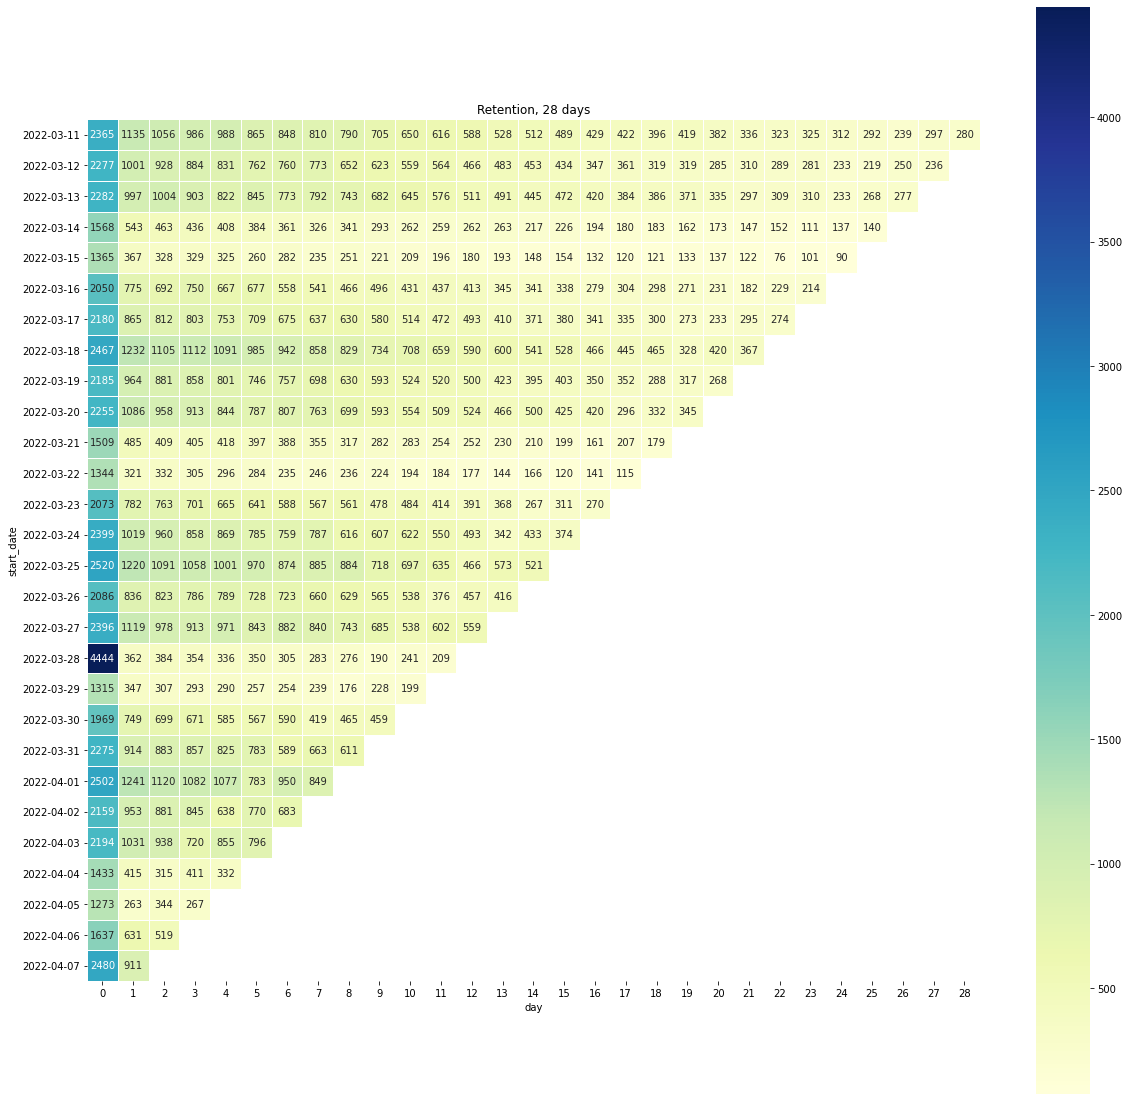

In [6]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set(title="Retention, 28 days")
sns.heatmap(retention, annot=True, fmt="g", mask=retention.isnull(), ax=ax, square=True, linewidths=.5, cmap='YlGnBu');

Вычислим Retention rate, разделив все значения строки на число пользователей первого дня 

In [8]:
retention_rate = retention.div(retention[0],axis=0) 

Тепловая карта для 28-дневного Retention rate

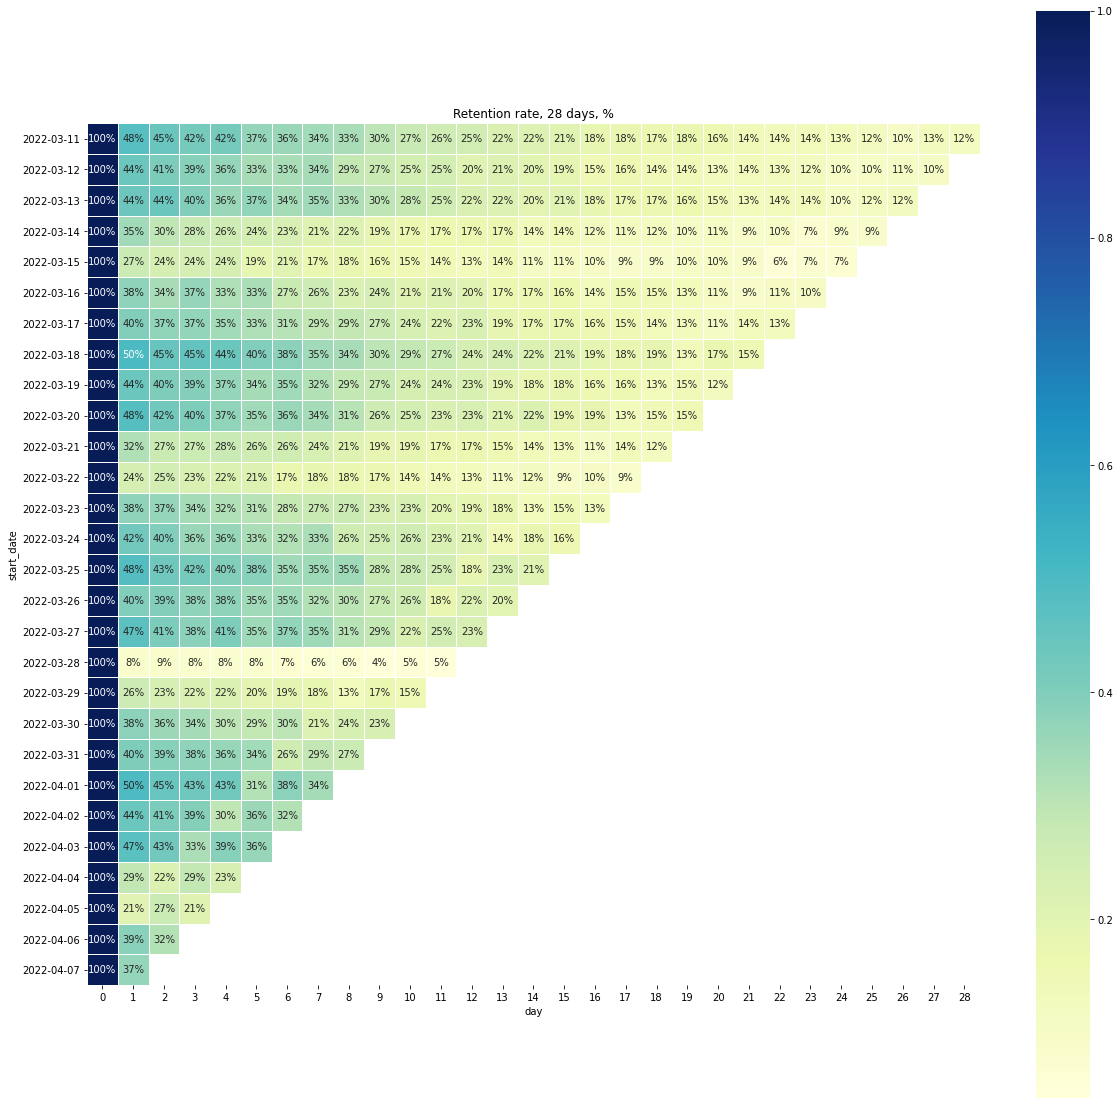

In [9]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set(title="Retention rate, 28 days, %")
sns.heatmap(retention_rate, annot=True, fmt='.0%', mask=retention_rate.isnull(), ax=ax, square=True, linewidths=.5, cmap='YlGnBu');

Сводная таблица только для пользователей из огранического источника

In [10]:
retention_organic = pd.pivot_table(df[df['source']=='organic'], columns=['day'], index='start_date', values='active_users', aggfunc=sum)

Тепловая карта Retention пользователей из огранического источника

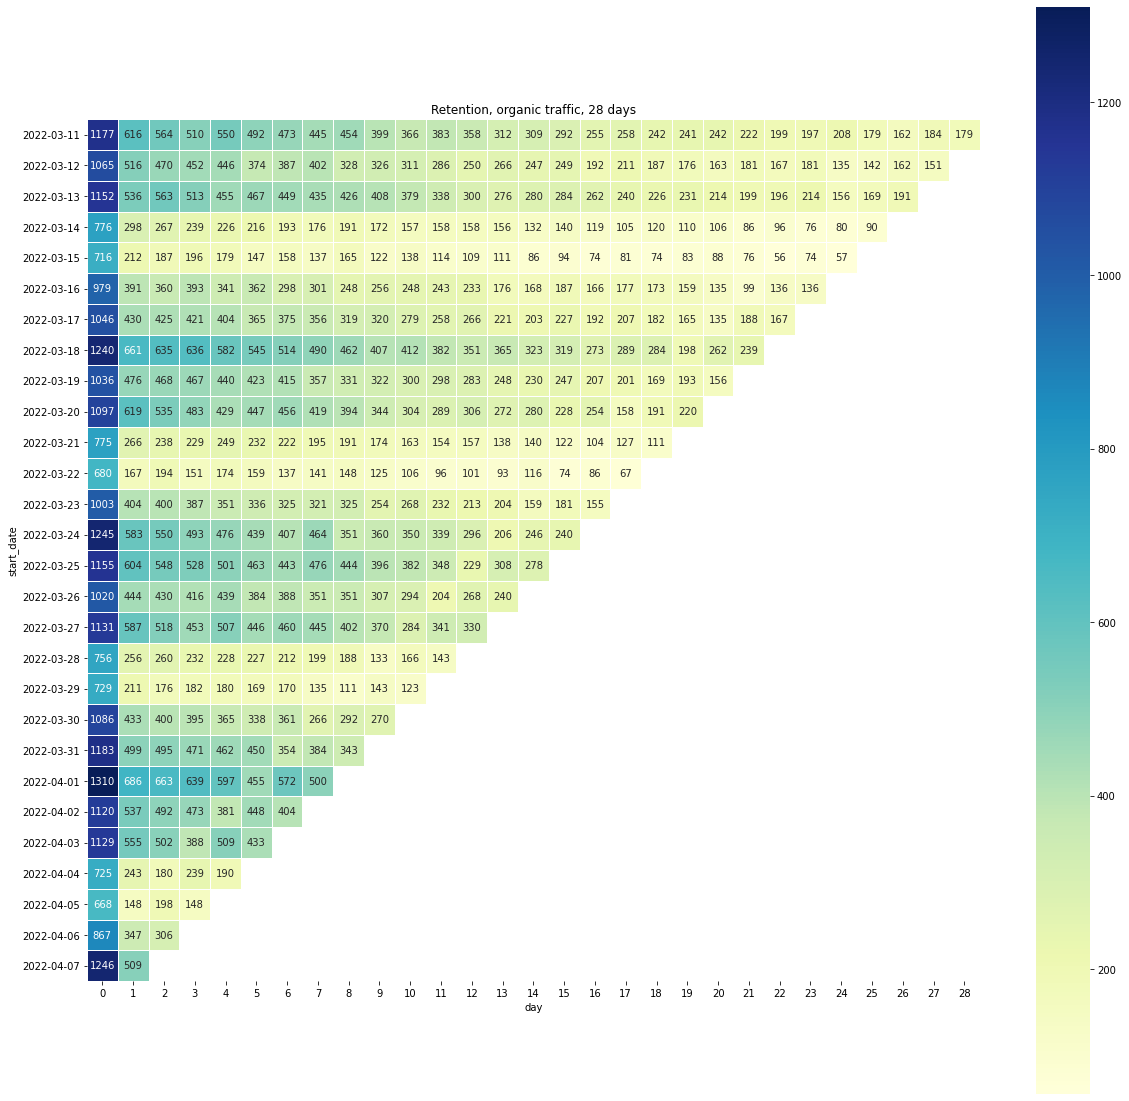

In [11]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set(title="Retention, organic traffic, 28 days")
sns.heatmap(retention_organic, annot=True, fmt="g", mask=retention_organic.isnull(), ax=ax, square=True, linewidths=.5, cmap='YlGnBu');

Аналогично получаем  Retention rate для пользователей из огранического источника

In [12]:
retention_rate_organic = retention_organic.div(retention_organic[0],axis=0) 

Тепловая карта для 28-дневного Retention rate пользователей из органического трафика

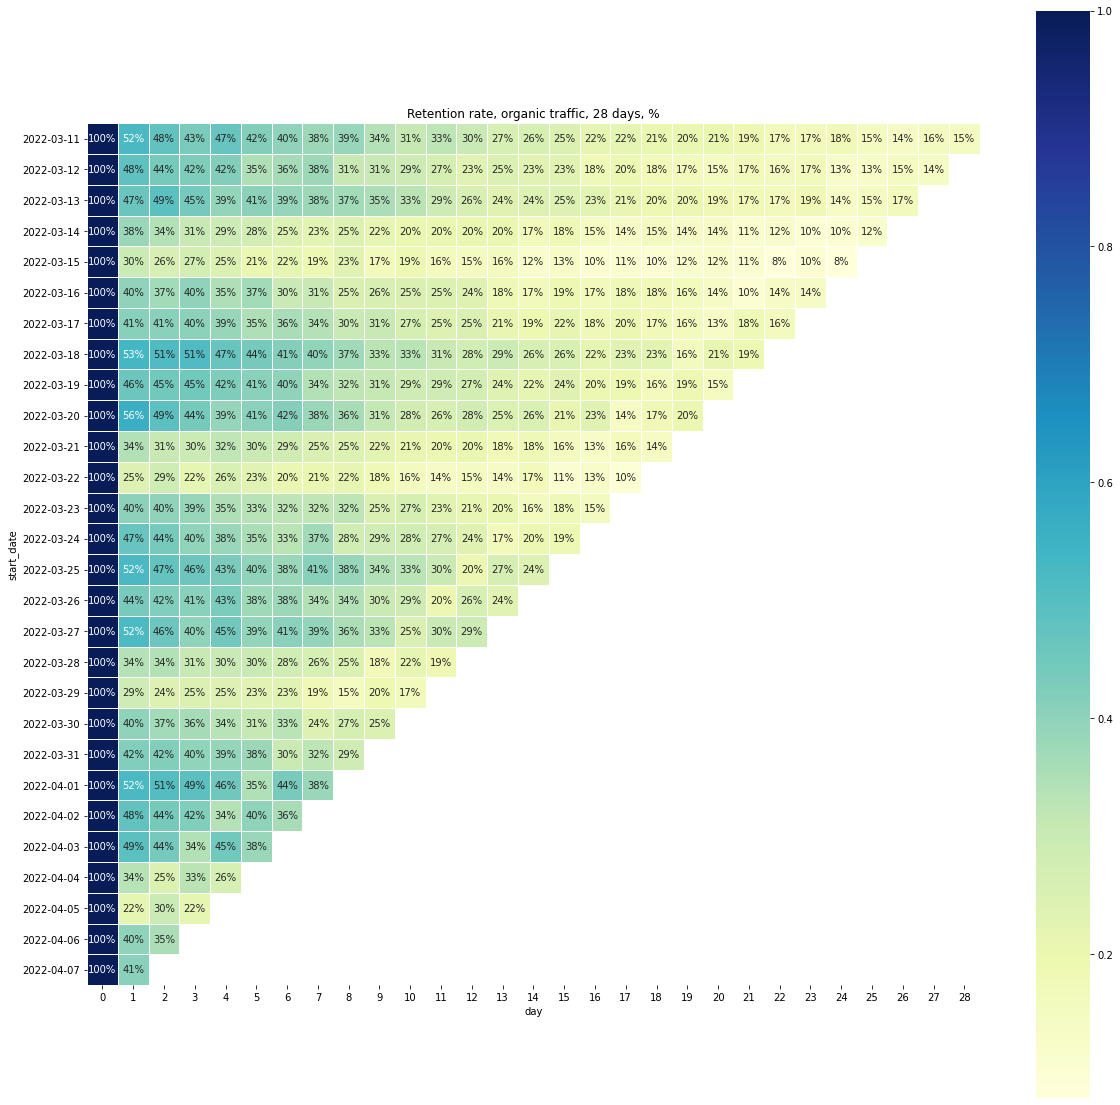

In [13]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set(title="Retention rate, organic traffic, 28 days, %")
sns.heatmap(retention_rate_organic, annot=True, fmt='.0%', mask=retention_rate_organic.isnull(), ax=ax, square=True, linewidths=.5, cmap='YlGnBu');

Сводная таблица только для пользователей из рекламного источника

In [14]:
retention_ads = pd.pivot_table(df[df['source']=='ads'], columns=['day'], index='start_date', values='active_users', aggfunc=sum)

Тепловая карта Retention пользователей из рекламного источника

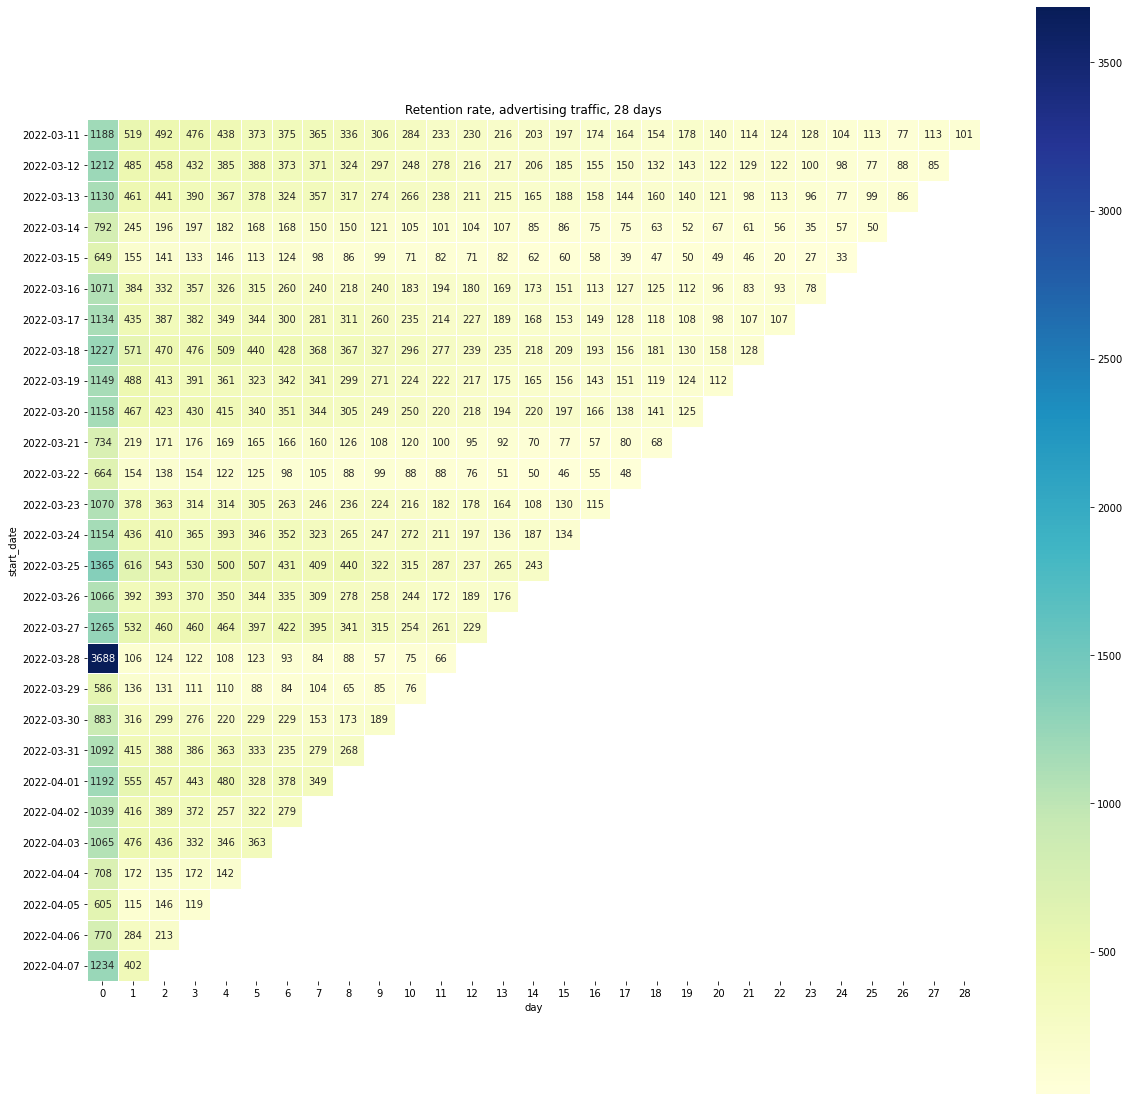

In [15]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set(title="Retention rate, advertising traffic, 28 days")
sns.heatmap(retention_ads, annot=True, fmt="g", mask=retention_ads.isnull(), ax=ax, square=True, linewidths=.5, cmap='YlGnBu');

Retention rate для пользователей из рекламного источника

In [16]:
retention_rate_ads = retention_ads.div(retention_ads[0],axis=0) 

Тепловая карта для 28-дневного Retention rate пользователей из рекламного трафика

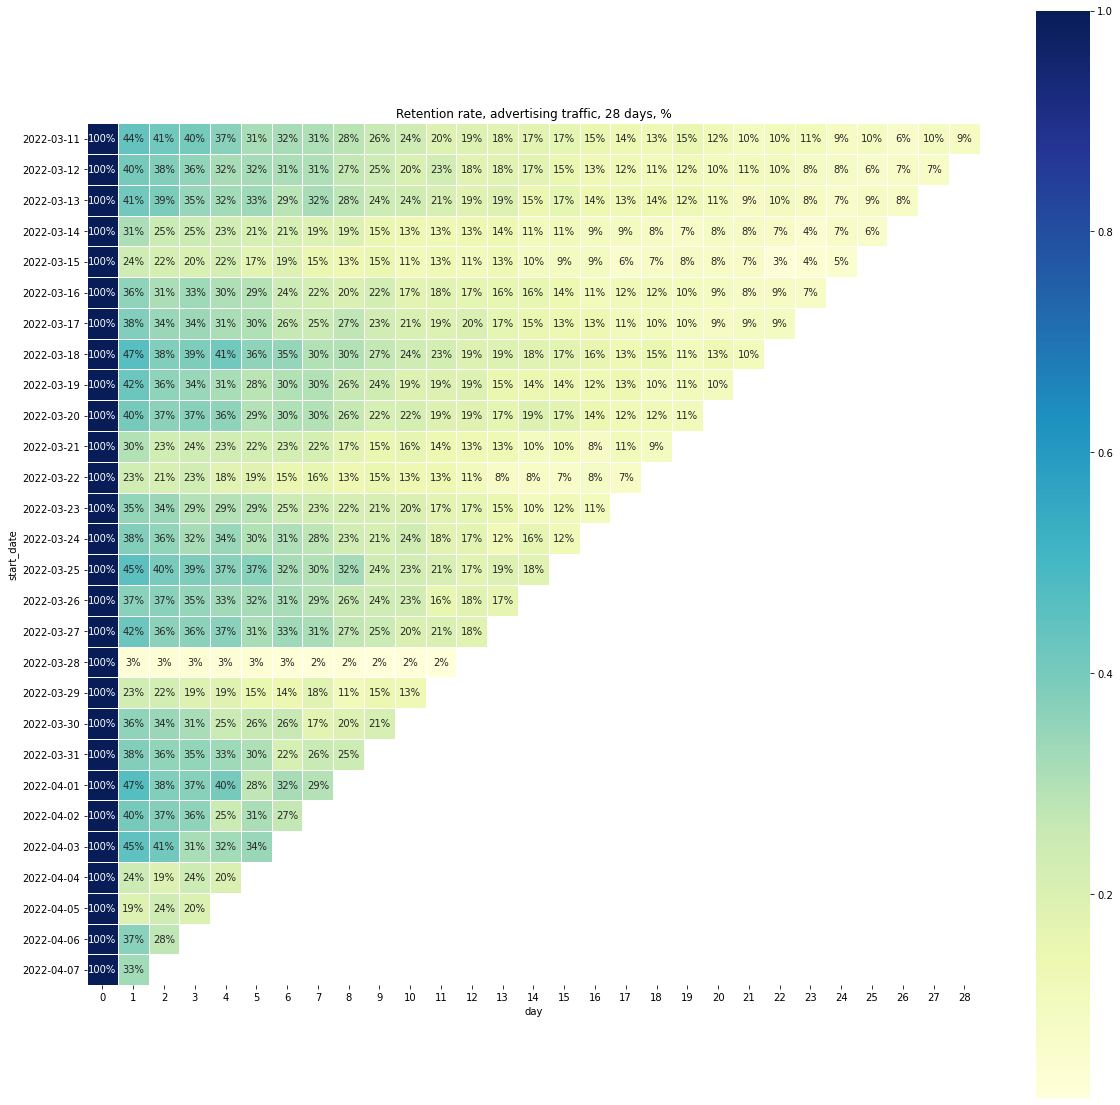

In [17]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set(title="Retention rate, advertising traffic, 28 days, %")
sns.heatmap(retention_rate_ads, annot=True, fmt='.0%', mask=retention_rate_ads.isnull(), ax=ax, square=True, linewidths=.5, cmap='YlGnBu');